In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#pillow
import PIL
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


2024-07-28 12:41:22.891552: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 12:41:22.891679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 12:41:23.015015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path='/kaggle/input/weather-dataset/dataset'

In [3]:
import os
classes=os.listdir(dataset_path)

In [4]:
data = []
class_number = 0
# Loop through the folders of the main dataset
for folder in os.listdir(dataset_path):
    # Take the folder path
    folder_path = os.path.join(dataset_path, folder)
    # Loop through the images in each folder
    for image in sorted(os.listdir(folder_path)):
        # Take the image path
        image_path = os.path.join(folder_path, image)
        # Save the image name, path, folder name and class number (label) in the list data
        data.append((image_path, image, folder, class_number))
    # Class_number is increased (next class/label)
    class_number += 1

# Create DataFrame with the data from the list data
df = pd.DataFrame(data, columns=['image_path','image_name', 'label_name', 'label_number'])

In [5]:
df

,image_path,image_name,label_name,label_number
0,/kaggle/input/weather-dataset/dataset/hail/000...,0000.jpg,hail,0
1,/kaggle/input/weather-dataset/dataset/hail/000...,0001.jpg,hail,0
2,/kaggle/input/weather-dataset/dataset/hail/000...,0002.jpg,hail,0
3,/kaggle/input/weather-dataset/dataset/hail/000...,0003.jpg,hail,0
4,/kaggle/input/weather-dataset/dataset/hail/000...,0004.jpg,hail,0
...,...,...,...,...
6857,/kaggle/input/weather-dataset/dataset/dew/2901...,2901.jpg,dew,10
6858,/kaggle/input/weather-dataset/dataset/dew/2902...,2902.jpg,dew,10
6859,/kaggle/input/weather-dataset/dataset/dew/2903...,2903.jpg,dew,10
6860,/kaggle/input/weather-dataset/dataset/dew/2904...,2904.jpg,dew,10


In [6]:
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split

def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    resized_image = image.resize((224, 224))
    return np.array(resized_image, dtype=np.float32)  # Explicitly set dtype

image_list = []
label_list = []

dataset_path = Path(dataset_path)  # Make sure this is a Path object

for index, label in enumerate(classes):
    for image_path in dataset_path.glob(f"{label}/*"):
        image_array = load_and_preprocess_image(image_path)
        image_list.append(image_array)
        label_list.append(index)

# Convert lists to NumPy arrays
X = np.array(image_list)
y = np.array(label_list)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Type of X_train: {type(X_train)}")
print(f"Shape of X_train: {X_train.shape}")

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

print(f"Min and max values in X_train after normalization: {X_train.min()}, {X_train.max()}")

Shape of X: (6862, 224, 224, 3)
Shape of y: (6862,)
Type of X_train: <class 'numpy.ndarray'>
Shape of X_train: (4803, 224, 224, 3)
Min and max values in X_train after normalization: 0.0, 1.0


In [7]:
X_train[0][0][0]

array([0.41960785, 0.56078434, 0.11764706], dtype=float32)

# Class Balance

hail: 591 images
rainbow: 232 images
frost: 475 images
rime: 1160 images
fogsmog: 851 images
snow: 621 images
rain: 526 images
glaze: 639 images
lightning: 377 images
sandstorm: 692 images
dew: 698 images


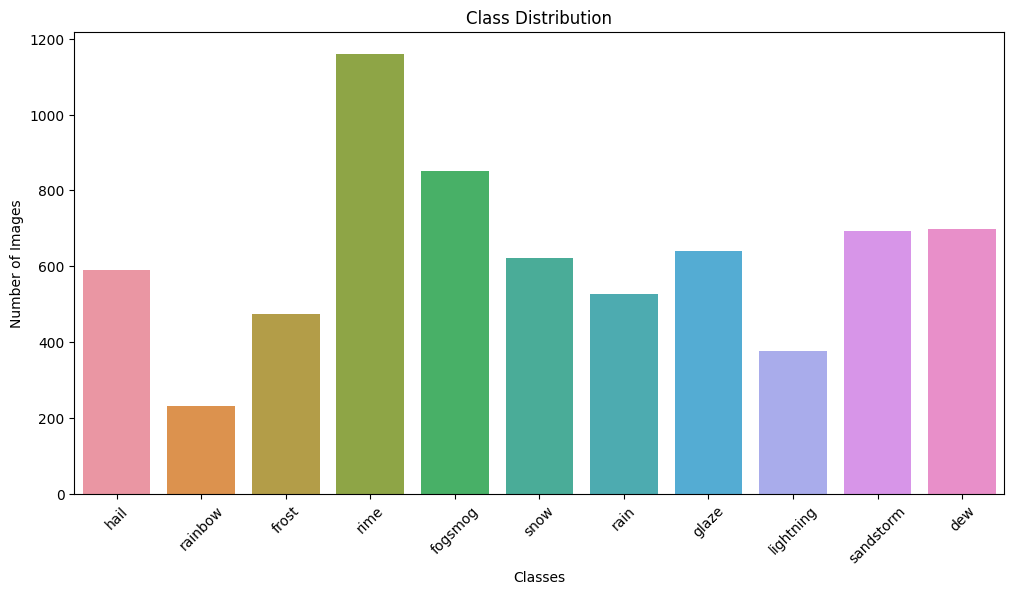

In [8]:
# Get the list of classes
classes = os.listdir(dataset_path)
class_counts = {}

# Count the number of images in each class
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Print the counts
for class_name, count in class_counts.items():
    print(f'{class_name}: {count} images')

# Visualize the counts
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Define augmentation parameters
train_augmentations = ImageDataGenerator(
    # Rotation from -30 to +30 degrees
    rotation_range=0.4,
    # Shear by 20%
    shear_range=0.2,
    # Shift horizontally by 10%
    width_shift_range=0.1,
    # Shift vertically by 10%
    height_shift_range=0.1,
    # Flip horizontally
    horizontal_flip=True,
    # Fill new pixels with nearest existing pixel to not lose pixels 
    fill_mode='nearest')

# Create a generator to pass the data in batches with the augmentations
train_generator = train_augmentations.flow(
    X_train,
    y_train,
    # 32 images will be passed at a time
    batch_size=32)

In [10]:
# Define augmentation parameters
test_augmentations = ImageDataGenerator()

# Create a generator to pass the data in batches with the augmentations
test_generator = test_augmentations.flow(
    X_test,
    y_test,
    batch_size=32)

(224, 224, 3)


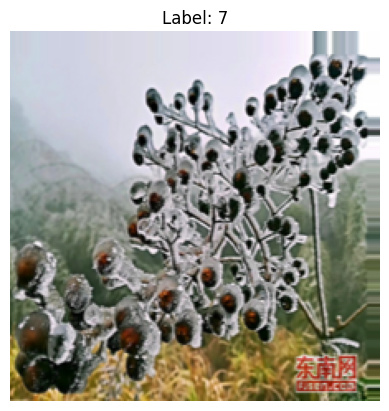

In [11]:
# Take the first image batch and the labels from train generator
images_batch, labels_batch = next(train_generator)
# Take the first image from the batch
image_to_preview = images_batch[0]

print(image_to_preview.shape)
# Display the image
plt.imshow(image_to_preview)
plt.title(f"Label: {labels_batch[0]}")
plt.axis('off')
plt.show()

In [12]:
#  This is useful in training neural networks where you want to start with a higher learning rate and gradually decrease it as training progresses to fine-tune the model's weights.
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
# If the validation loss (val_loss) doesn't improve for some epochs (based on patiance), the learning rate is reduced by the factor we set
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,min_lr=1e-4)


In [ ]:
#test 
model_CNN6 = Sequential()
model_CNN6.add(Conv2D(30,(4,4),input_shape=(224, 224, 3),activation="relu"))
model_CNN6.add(MaxPooling2D(pool_size = (2,2)))
model_CNN6.add(Conv2D(20, (3, 3), activation="relu"))
model_CNN6.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN6.add(Flatten())
model_CNN6.add(Dense(128, activation ="relu"))
model_CNN6.add(Dense(60, activation ="relu"))
model_CNN6.add(Dense(30, activation ="relu"))
model_CNN6.add(Dense(20, activation ="relu"))
model_CNN6.add(Dense(11, activation ="softmax"))
model_CNN6.compile(loss ="sparse_categorical_crossentropy", optimizer ="adam", metrics =["accuracy"])
model_CNN6.summary()
early_stop = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True )
history1 = model_CNN6.fit(train_generator, 
                          epochs=100, 
                          verbose=1,
                          validation_data=(X_val, y_val),
                          callbacks=[early_stop])

In [ ]:
history_1_1 = model_CNN6.fit(X_train,y_train,
                        epochs=20,
                        validation_data=(X_val,y_val),
                        callbacks=[early_stopping, lr_scheduler]
                       )

In [ ]:
test_acc = model_CNN6.evaluate(X_test, y_test, verbose=0)[1]
print('model_CNN6 Accuracy on Test Data:', round(test_acc, 3))

In [ ]:
test_acc = model_CNN6.evaluate(test_generator, verbose=0)[1]
print('model_CNN6 Accuracy on Test_generator Data:', round(test_acc, 3))

In [ ]:
from tensorflow.keras.regularizers import l2  


In [ ]:
input_shape = X_train.shape[1:]
dropout_rate = 0.3

model_3 = keras.models.Sequential([
    # Input layer
    # 128 filters, 5x5 filter size, "valid" padding (no padding), ReLU activation function, input shape of the images
    keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='valid', activation="relu", input_shape=input_shape),
    # MaxPooling layer
    # Max pooling operation with a 2x2 pool size, reducing spatial dimensions by half
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # BatchNormalization layer
    # Normalizes and scales inputs to each layer, improving training speed and stability
    keras.layers.BatchNormalization(),

    # Second Convolutional layer
    # 64 filters, 3x3 filter size, "valid" padding, ReLU activation function, L2 regularization with regularization parameter 0.00005
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation="relu", kernel_regularizer=l2(0.00005)),
    # MaxPooling layer
    # Max pooling operation with a 2x2 pool size, reducing spatial dimensions by half
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # BatchNormalization layer
    # Normalizes and scales inputs to each layer
    keras.layers.BatchNormalization(),

    # Third Convolutional layer
    # 32 filters, 3x3 filter size, "valid" padding, ReLU activation function, L2 regularization with regularization parameter 0.00005
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation="relu", kernel_regularizer=l2(0.00005)),
    # MaxPooling layer
    # Max pooling operation with a 2x2 pool size, reducing spatial dimensions by half
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # BatchNormalization layer
    # Normalizes and scales inputs to each layer
    keras.layers.BatchNormalization(),

    # Flatten layer
    # Converts the 2D matrix into a 1D vector.
    # Essential before feeding data into fully connected layers
    keras.layers.Flatten(),
    
    # First Dense layer
    # Fully connected layer with 256 neurons, ReLU activation function
    keras.layers.Dense(units=256, activation='relu'),
    
    # Dropout layer
    # Dropout rate of 30% to prevent overfitting by randomly setting 30% of input units to 0
    keras.layers.Dropout(dropout_rate),
    
    # Output layer
    # 11 neurons, corresponding to the number of classes
    # Softmax ensures sum of probabilities is 1
    keras.layers.Dense(units=11, activation='softmax')
])

# Summary of the model
model_3.summary()

# Adam optimizer, Loss function for multi-class classification
model_3.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])


In [ ]:
history_3 = model_3.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),callbacks=[early_stopping,lr_scheduler],verbose=1)

In [ ]:
test_acc = model_3.evaluate(X_test, y_test, verbose=0)[1]
print('model_3 Accuracy on Test Data:', round(test_acc, 3))

# Pre_Trained Model ( Xception Model Architectur)

In [13]:
input_shape = (224, 224, 3)  # Adjust these values based on your actual image dimensions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import Xception

Xception_model = Sequential([
    Input(shape=input_shape),
    Xception(include_top=False, weights='imagenet', input_shape=input_shape),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(classes), activation='softmax')
])


Xception_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Xception_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,427,891 (81.74 MB)

 Trainable params: 21,373,363 (81.53 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [14]:
history_5 = Xception_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),callbacks=[early_stopping,lr_scheduler],verbose=1)

Epoch 1/20


I0000 00:00:1722170665.159235     970 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722170665.238888     970 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.5449 - loss: 1.3886

W0000 00:00:1722170734.108405     970 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/151 ━━━━━━━━━━━━━━━━━━━━ 147s 499ms/step - accuracy: 0.5458 - loss: 1.3864 - val_accuracy: 0.4509 - val_loss: 4.0316 - learning_rate: 0.0010
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.7757 - loss: 0.7781 - val_accuracy: 0.7143 - val_loss: 1.2068 - learning_rate: 0.0010
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.8087 - loss: 0.6863 - val_accuracy: 0.8086 - val_loss: 0.8989 - learning_rate: 0.0010
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.8662 - loss: 0.4947 - val_accuracy: 0.8562 - val_loss: 0.5034 - learning_rate: 0.0010
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.8950 - loss: 0.4037 - val_accuracy: 0.8115 - val_loss: 0.7432 - learning_rate: 0.0010
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.9028 - loss: 0.3873 - val_accuracy: 0.7318 - val_loss: 1.0046 - learning_rate: 0.0010
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.8811 - loss

In [15]:
test_acc = Xception_model.evaluate(X_test, y_test, verbose=0)[1]
print('Xception_model Accuracy on Test Data:', round(test_acc, 3))

Xception_model Accuracy on Test Data: 0.916


In [16]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models

input_shape = (224, 224, 3)  # Adjust as needed

base_model = ResNet50V2(include_top=False, input_shape=input_shape)
base_model.trainable = False

inputs = layers.Input(shape=input_shape)
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(11, activation="softmax")(x)

ResNet50V2_model = models.Model(inputs, outputs)

ResNet50V2_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,123,659 (92.02 MB)

 Trainable params: 558,859 (2.13 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [17]:
ResNet50V2_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [18]:
history_6 =ResNet50V2_model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, lr_scheduler],verbose=1
                       )

Epoch 1/20
  5/151 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.1084 - loss: 2.8533 

W0000 00:00:1722171551.345769     972 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4760 - loss: 1.6154

W0000 00:00:1722171571.254551     972 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 171ms/step - accuracy: 0.4769 - loss: 1.6124 - val_accuracy: 0.8212 - val_loss: 0.5233 - learning_rate: 0.0010
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7664 - loss: 0.6753 - val_accuracy: 0.8533 - val_loss: 0.4270 - learning_rate: 0.0010
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8328 - loss: 0.4932 - val_accuracy: 0.8776 - val_loss: 0.4124 - learning_rate: 0.0010
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8565 - loss: 0.4272 - val_accuracy: 0.8707 - val_loss: 0.4120 - learning_rate: 0.0010
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8807 - loss: 0.3522 - val_accuracy: 0.8756 - val_loss: 0.4211 - learning_rate: 0.0010
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8869 - loss: 0.3158 - val_accuracy: 0.8814 - val_loss: 0.3905 - learning_rate: 0.0010
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9126 - loss: 0.2517 - va

In [19]:
test_acc =Xception_model .evaluate(X_test, y_test, verbose=0)[1]
print('Xception_model Accuracy on Test Data:', round(test_acc, 3))

test_acc = ResNet50V2_model.evaluate(X_test, y_test, verbose=0)[1]
print('ResNet50V2_model Accuracy on Test Data:', round(test_acc, 3))

Xception_model Accuracy on Test Data: 0.916
ResNet50V2_model Accuracy on Test Data: 0.83


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step


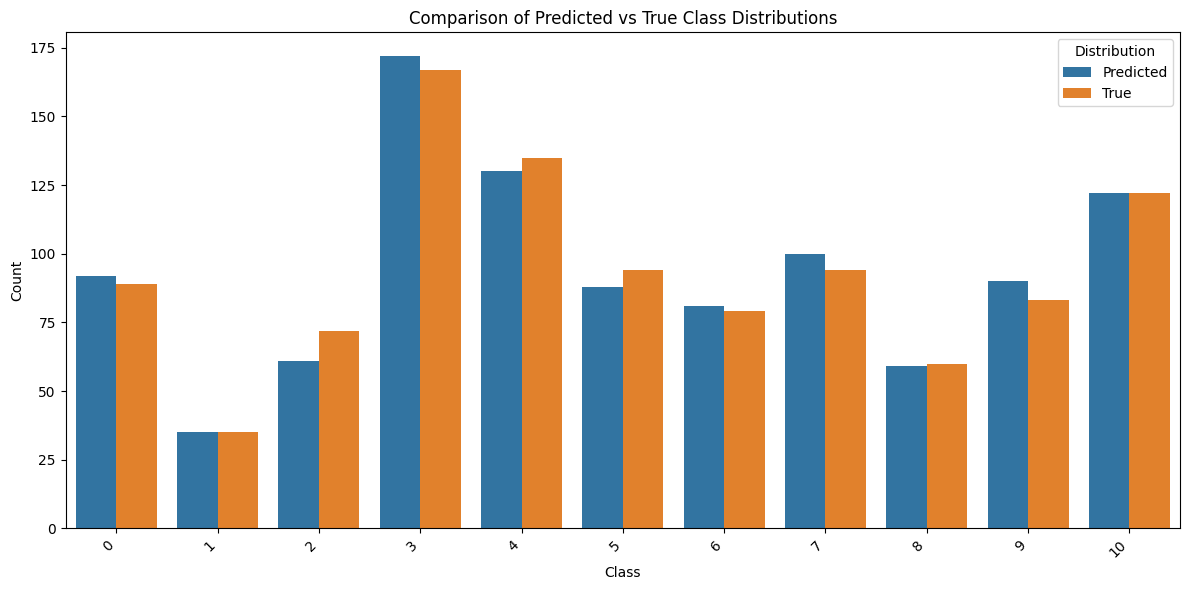

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assume you have y_pred and y_test
y_pred = np.argmax(Xception_model.predict(X_test), axis=-1)

# Create a function to get counts as a dictionary
def get_counts(y):
    unique_values, value_counts = np.unique(y, return_counts=True)
    return {k:v for k,v in zip(unique_values, value_counts)}

# Get counts for predicted and true values
pred_counts = get_counts(y_pred)
true_counts = get_counts(y_test)

# Create a DataFrame for easy plotting
df = pd.DataFrame({
    'Class': list(set(pred_counts.keys()) | set(true_counts.keys())),
    'Predicted': [pred_counts.get(k, 0) for k in set(pred_counts.keys()) | set(true_counts.keys())],
    'True': [true_counts.get(k, 0) for k in set(pred_counts.keys()) | set(true_counts.keys())]
})

# Melt the DataFrame for seaborn
df_melted = pd.melt(df, id_vars=['Class'], var_name='Distribution', value_name='Count')

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', hue='Distribution', data=df_melted)

plt.title('Comparison of Predicted vs True Class Distributions')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Distribution')

# Rotate x-axis labels if there are many classes
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# or

In [ ]:
# y_pred = np.argmax(Xception_model.predict(X_test), axis=-1)
# unique_values, value_counts = np.unique(y_pred, return_counts=True)
# pred_counts = {k: v for k, v in zip(unique_values, value_counts)}
# unique_values, value_counts = np.unique(y_test, return_counts=True)
# target_counts = {k: v for k, v in zip(unique_values, value_counts)}

# plt.bar(np.array(list(pred_counts.keys())) - 0.2, pred_counts.values(), 0.4, label='predictions')
# plt.bar(np.array(list(target_counts.keys())) + 0.2, target_counts.values(), 0.4, label='target')
# plt.legend()

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step


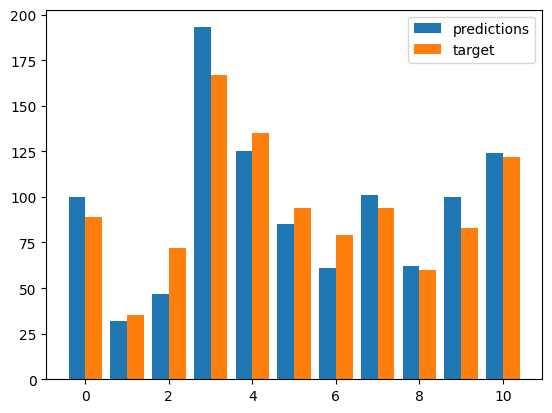

In [26]:
y_pred = np.argmax(ResNet50V2_model.predict(X_test), axis=-1)
unique_values, value_counts = np.unique(y_pred, return_counts=True)
pred_counts = {k: v for k, v in zip(unique_values, value_counts)}
unique_values, value_counts = np.unique(y_test, return_counts=True)
target_counts = {k: v for k, v in zip(unique_values, value_counts)}

plt.bar(np.array(list(pred_counts.keys())) - 0.2, pred_counts.values(), 0.4, label='predictions')
plt.bar(np.array(list(target_counts.keys())) + 0.2, target_counts.values(), 0.4, label='target')
plt.legend()

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Accuracy for class 'hail': 0.97
Accuracy for class 'rainbow': 1.00
Accuracy for class 'frost': 0.81
Accuracy for class 'rime': 0.92
Accuracy for class 'fogsmog': 0.93
Accuracy for class 'snow': 0.78
Accuracy for class 'rain': 0.92
Accuracy for class 'glaze': 0.84
Accuracy for class 'lightning': 0.98
Accuracy for class 'sandstorm': 0.96
Accuracy for class 'dew': 0.97


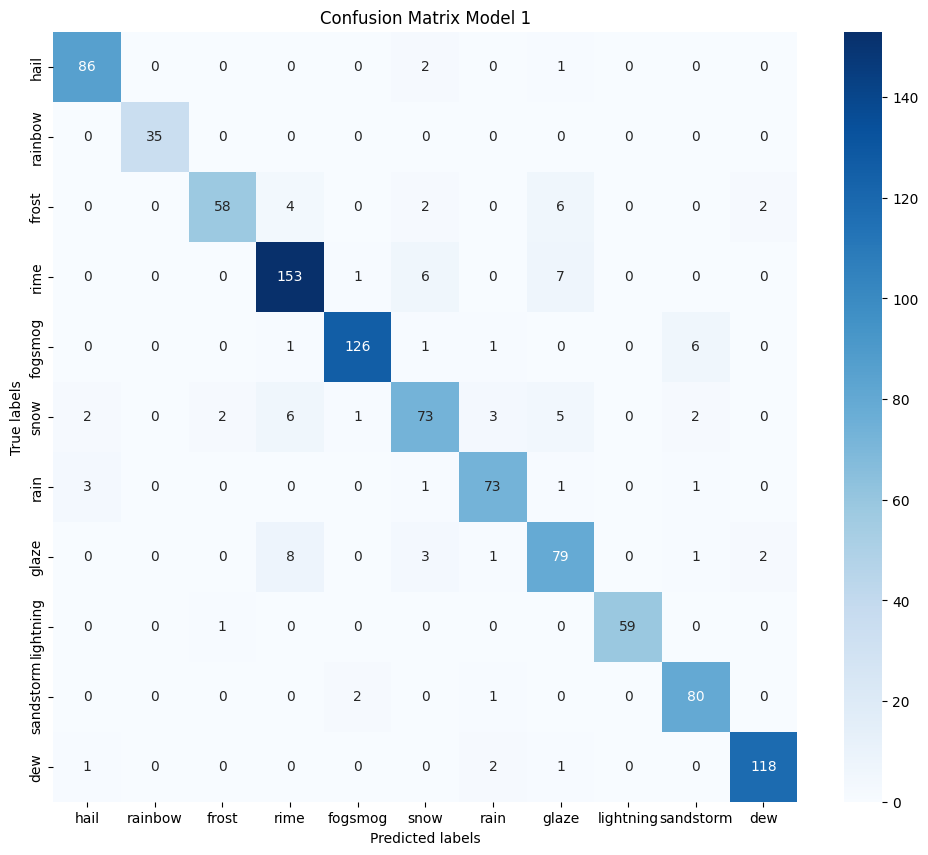

In [27]:
y_pred = np.argmax(Xception_model.predict(X_test), axis=-1)
conf_matrix = confusion_matrix(y_test, y_pred)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Model 1')

for i, label in enumerate(classes):
    print(f"Accuracy for class '{label}': {class_accuracy[i]:.2f}")

plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Accuracy for class 'hail': 0.96
Accuracy for class 'rainbow': 0.89
Accuracy for class 'frost': 0.58
Accuracy for class 'rime': 0.94
Accuracy for class 'fogsmog': 0.80
Accuracy for class 'snow': 0.64
Accuracy for class 'rain': 0.67
Accuracy for class 'glaze': 0.76
Accuracy for class 'lightning': 0.95
Accuracy for class 'sandstorm': 0.87
Accuracy for class 'dew': 0.92


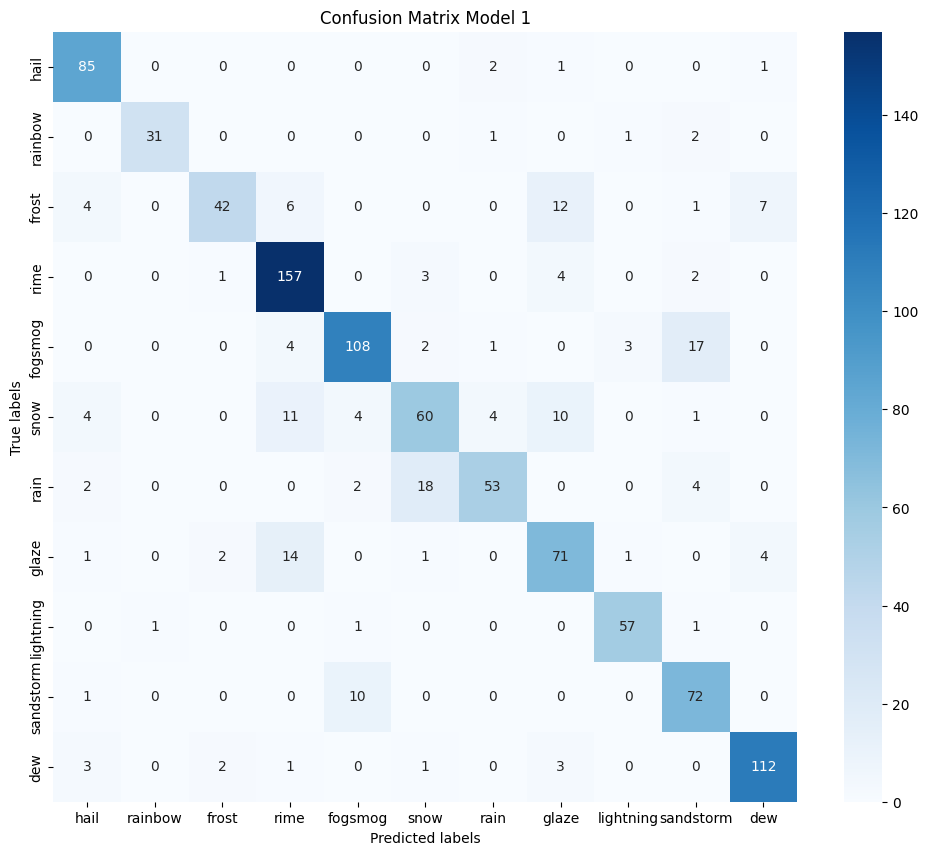

In [28]:
y_pred = np.argmax(ResNet50V2_model.predict(X_test), axis=-1)
conf_matrix = confusion_matrix(y_test, y_pred)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Model 1')

for i, label in enumerate(classes):
    print(f"Accuracy for class '{label}': {class_accuracy[i]:.2f}")

plt.show()

# Data Balancing (SMOTE)

###  it is not typically preferred for images. Despite this, it might be worth trying as it could potentially solve the imbalance problem.

In [20]:
if len(X_train) >2:
  X_train_reshaped = X_train.reshape(X_train.shape[0], -1)


In [21]:
X_train_reshaped.shape

(4803, 150528)

In [22]:
from collections import Counter

# By passing y_train to Counter, we obtain a dictionary object where key=label and the 
# corresponding value=number of times that class label appears in y_train
class_distribution = Counter(y_train)
print("Class distribution before SMOTE:", class_distribution)

# Find the minority class and its sample count
minority_class = min(class_distribution, key=class_distribution.get)
minority_class_count = class_distribution[minority_class]
print("Minority class:", minority_class)
print("Number of minority class samples:", minority_class_count)


Class distribution before SMOTE: Counter({3: 806, 4: 587, 9: 510, 10: 483, 7: 452, 5: 433, 0: 389, 6: 372, 2: 337, 8: 270, 1: 164})
Minority class: 1
Number of minority class samples: 164


In [23]:
# We limit the number of samples to use due to memory constraints 
num_samples = 1500
X_subset = X_train_reshaped[:num_samples]
y_subset = y_train[:num_samples]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_subset, y_subset)

In [24]:

print("Class distribution after SMOTE:", Counter(y_train_resampled))
print(X_train_resampled.shape)
print(y_train_resampled.shape)

Class distribution after SMOTE: Counter({10: 244, 9: 244, 4: 244, 3: 244, 5: 244, 6: 244, 7: 244, 0: 244, 8: 244, 1: 244, 2: 244})
(2684, 150528)
(2684,)


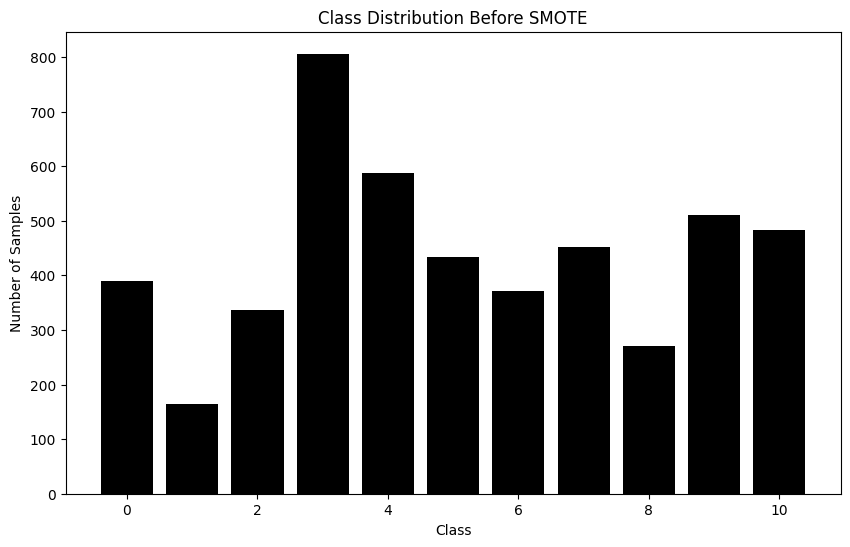

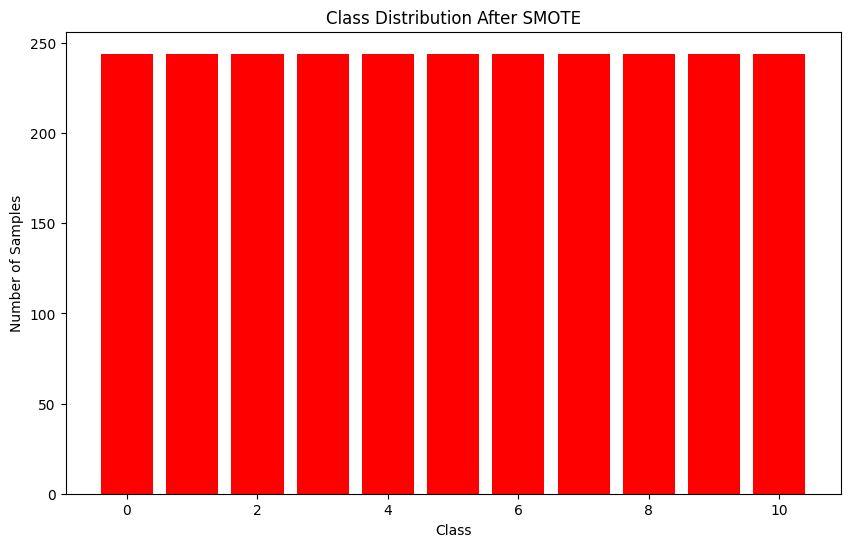

In [25]:
# Class distribution before SMOTE
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='black')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Class distribution after SMOTE
plt.figure(figsize=(10, 6))
smote_distribution = Counter(y_train_resampled)
plt.bar(smote_distribution.keys(), smote_distribution.values(), color='red')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

In [28]:
# SMOTE Subset Reshape for Model fit
X_smote_reshaped=X_train_resampled.reshape(X_train_resampled.shape[0], 224, 224, 3)
print (X_smote_reshaped.shape)
X_smote_reshaped=np.array(X_smote_reshaped)
X_smote_reshaped.shape

(2684, 224, 224, 3)


(2684, 224, 224, 3)

# Model 

In [29]:
input_shape = X_smote_reshaped.shape[1:]
dropout_rate = 0.3

model_SMOTE = keras.models.Sequential([
    # Input layer
    # 32 filters, 3x3 filter size, ReLU activation function, input shape of the images
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    # MaxPooling layer
    # Max pooling operation with a 2x2 pool size, reducing spatial dimensions by half
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Second Convolutional layer
    # 64 filters, 3x3 filter size, ReLU activation function
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    # MaxPooling layer
    # Max pooling operation with a 2x2 pool size, reducing spatial dimensions by half
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Flatten layer
    # Converts the 2D matrix into a 1D vector.
    # Essential before feeding data into fully connected layers
    keras.layers.Flatten(),
    
    # First Dense layer
    # Fully connected layer with 64 neurons.
    keras.layers.Dense(64, activation="relu"),
    # Output layer
    # 11 neurons, corresponding to the number of classes
    # Softmax ensures sum of probabilities is 1
    keras.layers.Dense(11, activation="softmax")
])

model_SMOTE.summary()

model_SMOTE.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,964,107 (45.64 MB)

 Trainable params: 11,964,107 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model_SMOTE_history = model_SMOTE.fit(X_smote_reshaped, y_train_resampled,
                                      epochs=20,
                                      validation_data=(X_val, y_val),
                                      callbacks=[early_stopping, lr_scheduler])

Epoch 1/20


2024-07-28 13:15:03.772453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-07-28 13:15:03.772521: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-07-28 13:15:03.772530: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-07-28 13:15:03.772544: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-07-28 13:15:03.772552: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-07-28 13:15:03.772560: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-07-28 13:15:03.772567: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-07-28 13:15:03.772575: E 

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2551 - loss: 5.4560

2024-07-28 13:15:09.644149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147859: 4.5423, expected 3.98255
2024-07-28 13:15:09.644216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147863: 4.02616, expected 3.46642
2024-07-28 13:15:09.644225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147864: 4.20688, expected 3.64714
2024-07-28 13:15:09.644233: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147914: 3.74231, expected 3.18257
2024-07-28 13:15:09.644241: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147917: 4.55879, expected 3.99905
2024-07-28 13:15:09.644249: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147935: 4.34856, expected 3.78882
2024-07-28 13:15:09.644257: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148028: 4.39055, expected 3.83081
2024-07-28 13:15:09.6

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2562 - loss: 5.4257

2024-07-28 13:15:16.379574: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 7.29527, expected 6.30731
2024-07-28 13:15:16.379650: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 8.30394, expected 7.31598
2024-07-28 13:15:16.379664: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 8.1388, expected 7.15084
2024-07-28 13:15:16.379677: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.28868, expected 5.30072
2024-07-28 13:15:16.379688: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.24086, expected 5.25291
2024-07-28 13:15:16.379702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.99145, expected 6.00349
2024-07-28 13:15:16.379716: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 7.16976, expected 6.18181
2024-07-28 13:15:16.379736: E external/local_xla/xla/ser

84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.2572 - loss: 5.3961 - val_accuracy: 0.3868 - val_loss: 1.7310 - learning_rate: 0.0010
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4186 - loss: 1.6952 - val_accuracy: 0.4344 - val_loss: 1.7301 - learning_rate: 0.0010
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5612 - loss: 1.3424 - val_accuracy: 0.4713 - val_loss: 1.6332 - learning_rate: 0.0010
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6665 - loss: 1.0067 - val_accuracy: 0.5656 - val_loss: 1.3599 - learning_rate: 0.0010
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7597 - loss: 0.7587 - val_accuracy: 0.5948 - val_loss: 1.2623 - learning_rate: 0.0010
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8292 - loss: 0.5496 - val_accuracy: 0.5442 - val_loss: 1.8766 - learning_rate: 0.0010
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8616 - loss: 0.4245 - val_accuracy: 0.

In [32]:
input_shape = X_smote_reshaped.shape[1:]

# Sequential model definition
Xception_model_SMOTE = keras.models.Sequential([
    # Base Xception model as the first layers
    base_model,
    
    # Global average pooling layer
    keras.layers.GlobalAveragePooling2D(),
    
    # Dense layer with 256 neurons and ReLU activation
    keras.layers.Dense(256, activation='relu'),
    
    # Dropout layer with 50% dropout rate to prevent overfitting
    keras.layers.Dropout(0.5),
    
    # Dense layer with 128 neurons and ReLU activation
    keras.layers.Dense(128, activation='relu'),
    
    # Dropout layer with 30% dropout rate
    keras.layers.Dropout(0.3),
    
    # Output layer with 11 neurons (number of classes) and softmax activation
    keras.layers.Dense(11, activation="softmax")
])

# Summary of the model
Xception_model_SMOTE.summary()

# Adam optimizer, sparse categorical crossentropy loss function, and accuracy metric
Xception_model_SMOTE.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [34]:
Xception_model_SMOTE_history = Xception_model_SMOTE.fit(X_smote_reshaped, y_train_resampled,
                                      epochs=20,
                                      validation_data=(X_val, y_val),
                                      callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
 4/84 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.1647 - loss: 2.8754 

W0000 00:00:1722172735.794989     973 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4136 - loss: 1.8017

W0000 00:00:1722172756.186853     973 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 288ms/step - accuracy: 0.4155 - loss: 1.7956 - val_accuracy: 0.7843 - val_loss: 0.6692 - learning_rate: 0.0010
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7927 - loss: 0.6334 - val_accuracy: 0.7959 - val_loss: 0.6168 - learning_rate: 0.0010
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8534 - loss: 0.4212 - val_accuracy: 0.7979 - val_loss: 0.6127 - learning_rate: 0.0010
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9093 - loss: 0.2939 - val_accuracy: 0.8144 - val_loss: 0.5713 - learning_rate: 0.0010
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9290 - loss: 0.2124 - val_accuracy: 0.8222 - val_loss: 0.6031 - learning_rate: 0.0010
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9283 - loss: 0.2033 - val_accuracy: 0.8251 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9516 - loss: 0.1432 - val_accuracy: 0.

In [35]:
test_acc = model_SMOTE.evaluate(test_generator, verbose=0)[1]
print('Model Accuracy on Test Data:', round(test_acc,3))

test_acc = Xception_model_SMOTE.evaluate(test_generator, verbose=0)[1]
print('Model Accuracy on Test Data:', round(test_acc,3))

2024-07-28 13:21:35.625284: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.75633, expected 4.15703
2024-07-28 13:21:35.625349: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 4.83207, expected 4.23277
2024-07-28 13:21:35.625369: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 4.497, expected 3.89771
2024-07-28 13:21:35.625383: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 4.81993, expected 4.22063
2024-07-28 13:21:35.625395: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180: 4.77272, expected 4.17342
2024-07-28 13:21:35.625405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 4.95521, expected 4.35591
2024-07-28 13:21:35.625416: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 182: 4.92335, expected 4.32405
2024-07-28 13:21:35.625427: E external/local_xl

Model Accuracy on Test Data: 0.36
Model Accuracy on Test Data: 0.774


In [36]:
test_acc = model_SMOTE.evaluate(X_test, y_test, verbose=0)[1]
print('Xception_model Accuracy on Test Data:', round(test_acc, 3))

test_acc = Xception_model_SMOTE.evaluate(X_test, y_test, verbose=0)[1]
print('Xception_model Accuracy on Test Data:', round(test_acc, 3))

Xception_model Accuracy on Test Data: 0.36
Xception_model Accuracy on Test Data: 0.774


# After Apllied SMOTE The Accuracy of model decrease  


# `Save the Model`

In [37]:
from tensorflow.keras.models import load_model


In [38]:
Xception_model.save(os.path.join('models','imageclassifier.h5'))

In [39]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 78.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.8 MB/s eta 0:00:00


In [40]:
!wget -q -O - ipv4.icanhazip.com

34.145.66.107


In [41]:
! streamlit run app.py & npx localtunnel --port 8501


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) npm notice 
npm notice New minor version of npm available! 10.1.0 -> 10.8.2
npm notice Changelog: https://github.com/npm/cli/releases/tag/v10.8.2
npm notice Run npm install -g npm@10.8.2 to update!
npm notice 
npm ERR! canceled

npm ERR! A complete log of this run can be found in: /root/.npm/_logs/2024-07-28T13_38_05_150Z-debug-0.log
